In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(2*1024))]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-16 09:02:11.165159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 09:02:11.240432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 09:02:11.240876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
DIRECTORY = 'dataset_work'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 8
COLOR_MODE='grayscale'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 11080 files belonging to 8 classes.
Using 8864 files for training.


2022-11-16 09:02:12.504729: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 09:02:12.505911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 09:02:12.506652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 09:02:12.507237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Found 11080 files belonging to 8 classes.
Using 2216 files for validation.


In [4]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
1122         1099         1101         1104         1127         1094         1119         1098        


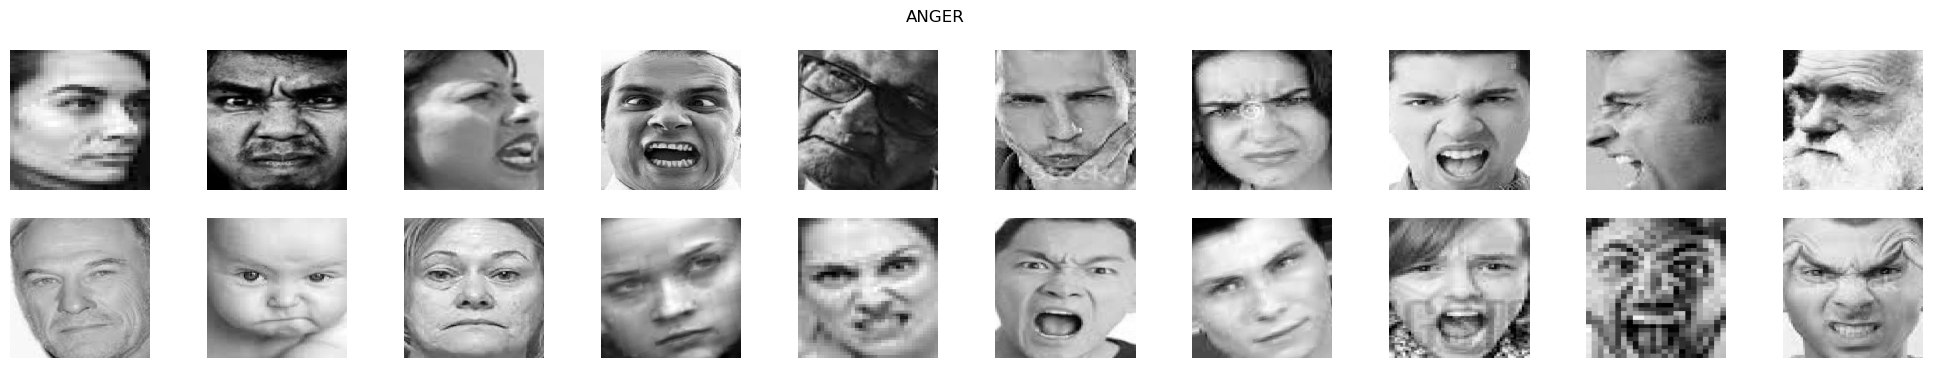

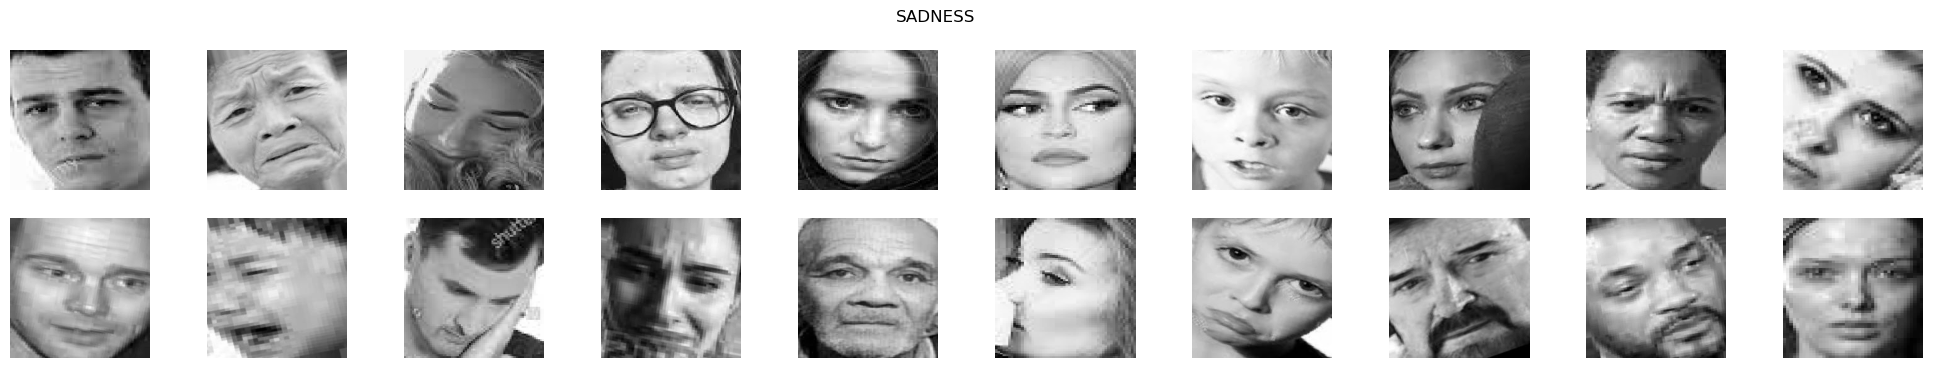

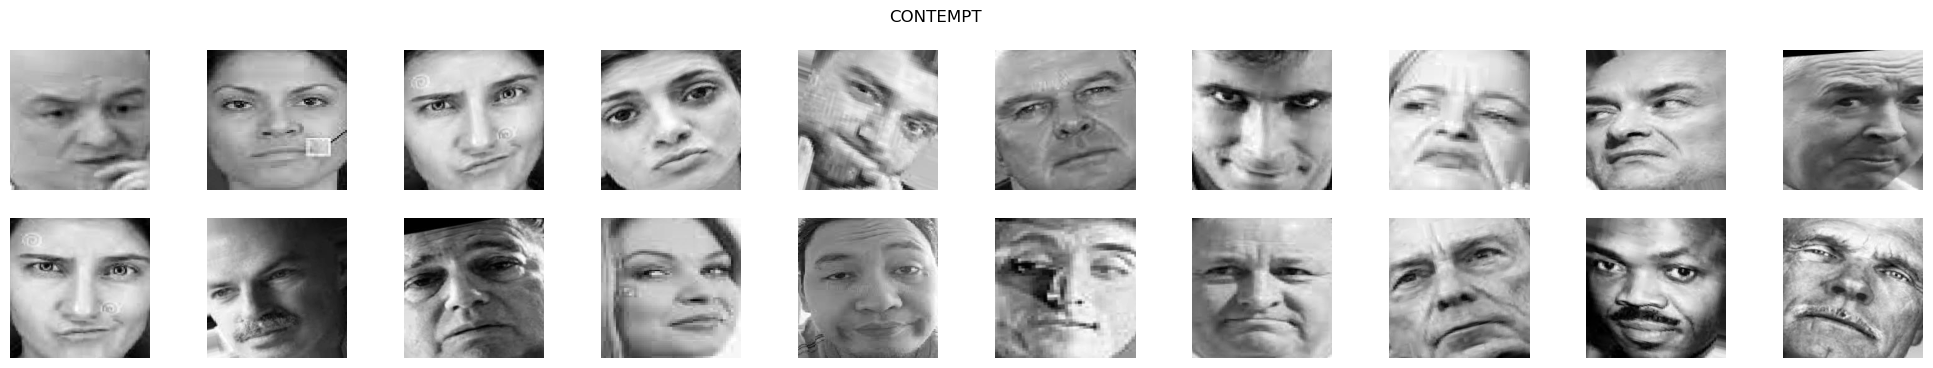

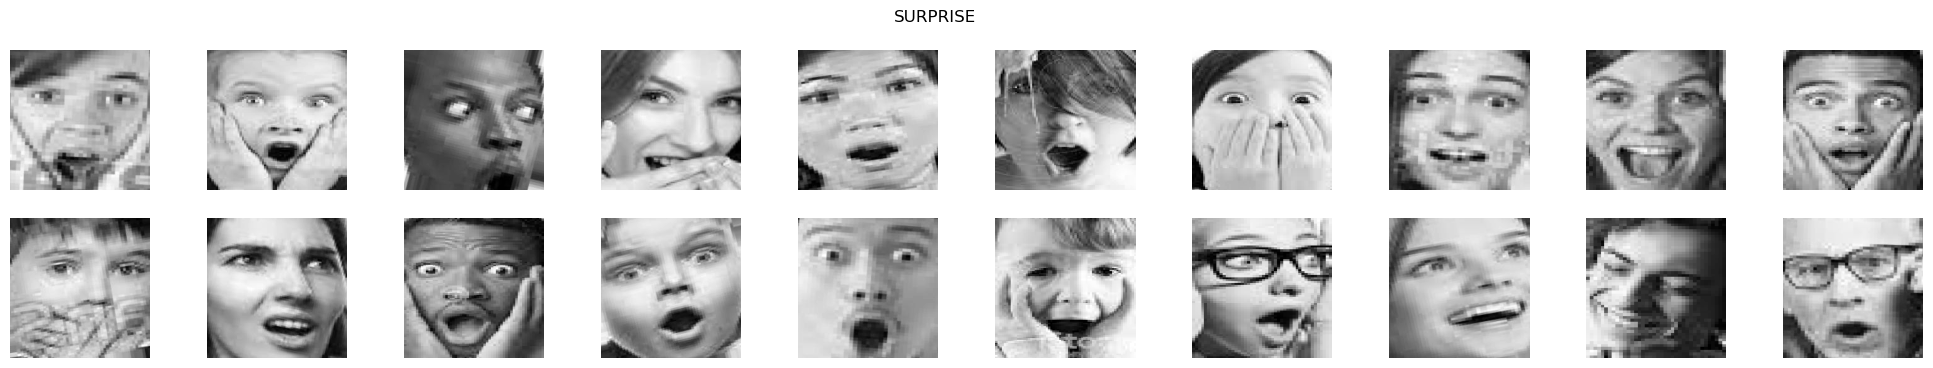

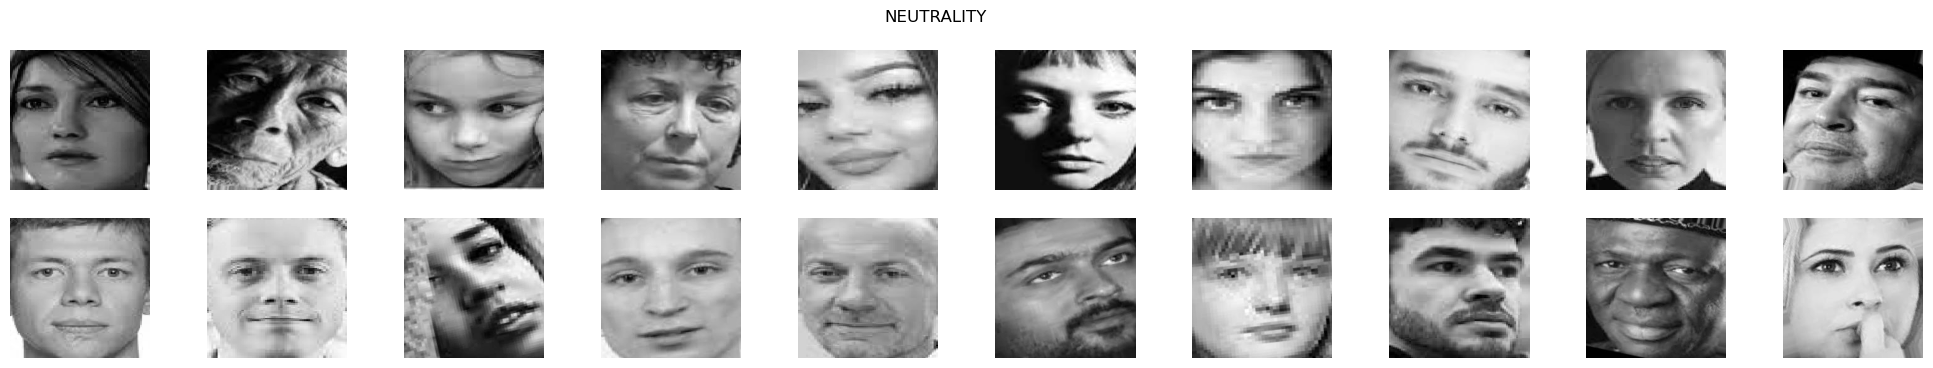

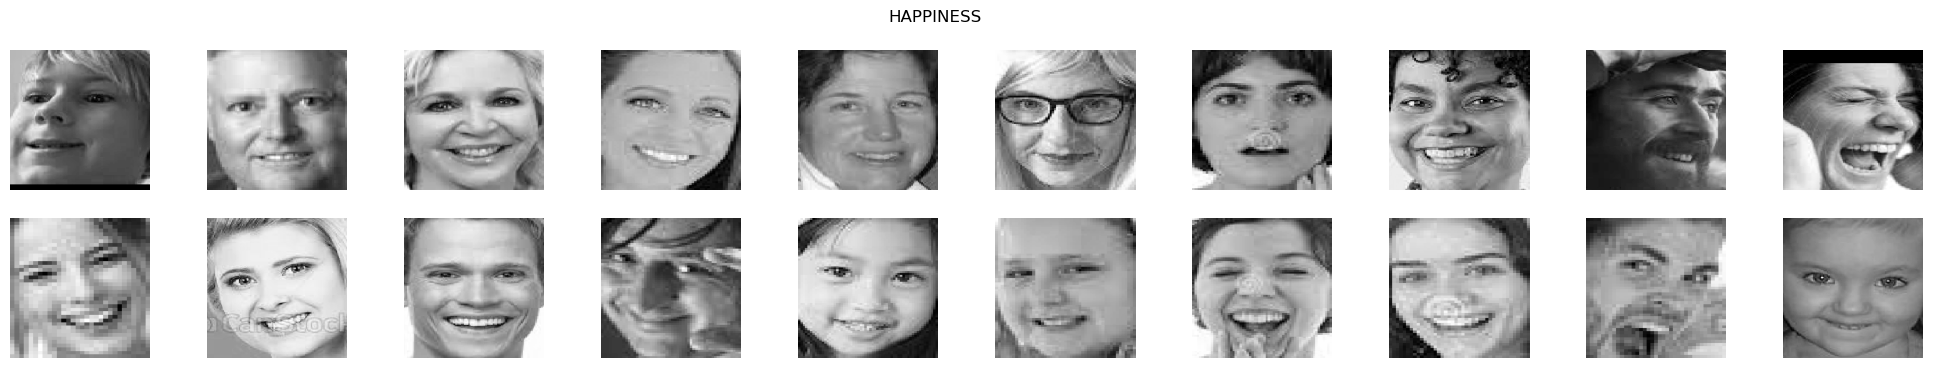

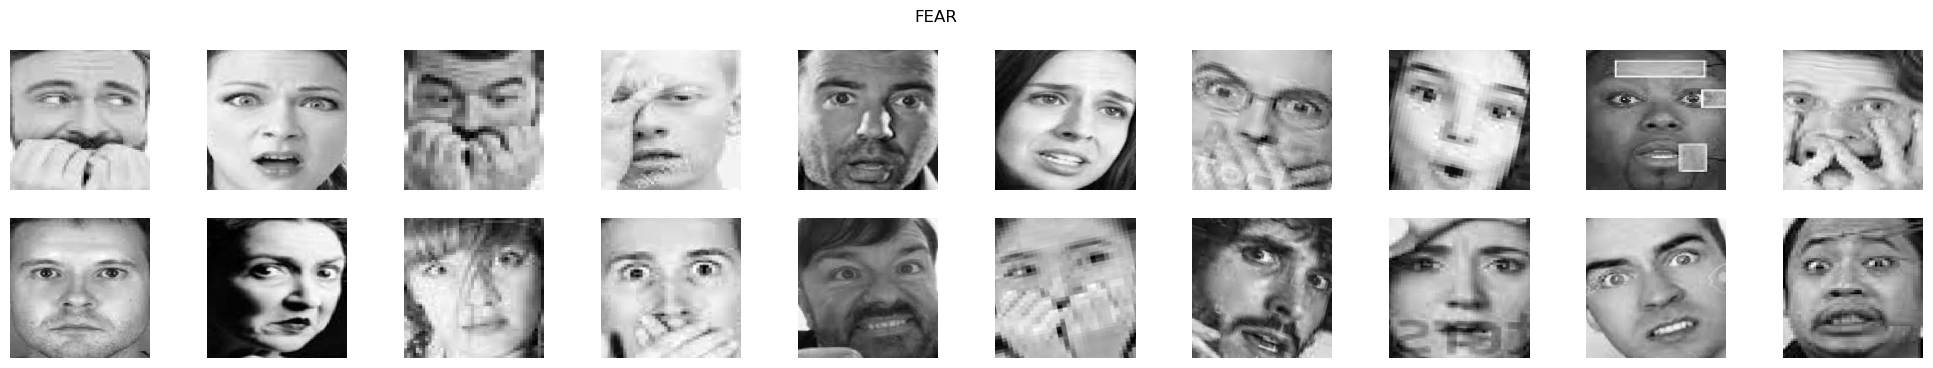

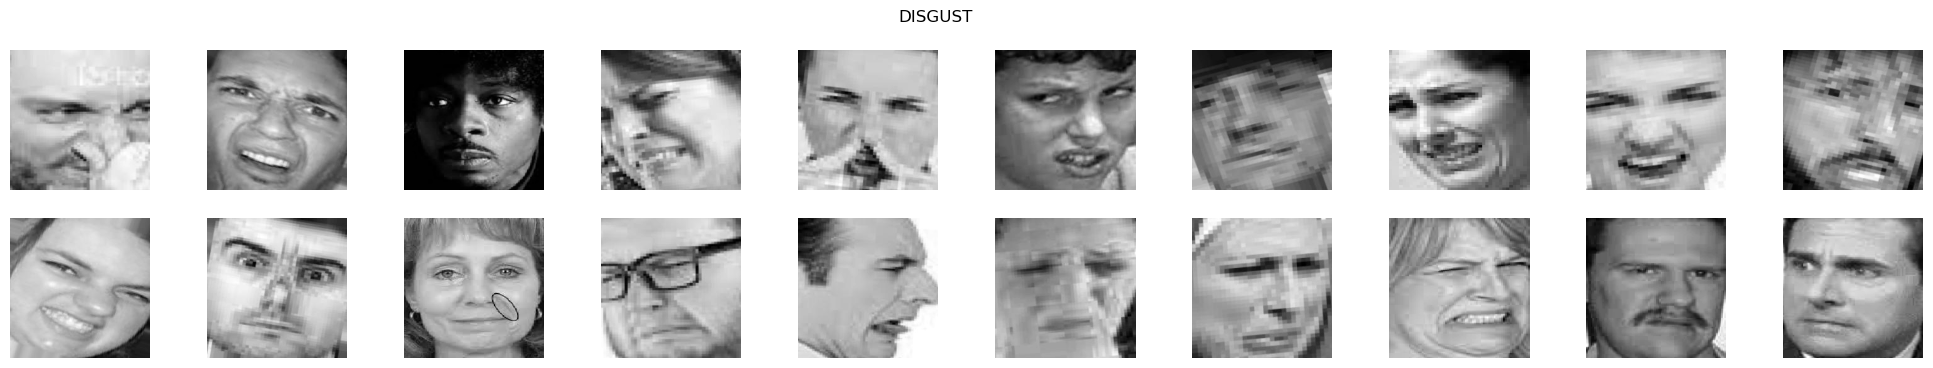

In [5]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        #axs[i].suptitle(class_names[label], y=-0.20)
        axs[i].axis("off")    

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 277
Number of test batches: 55


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
ZOOM = (0.0, -0.2)
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
        , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=ZOOM, width_factor=ZOOM)
    ]
)

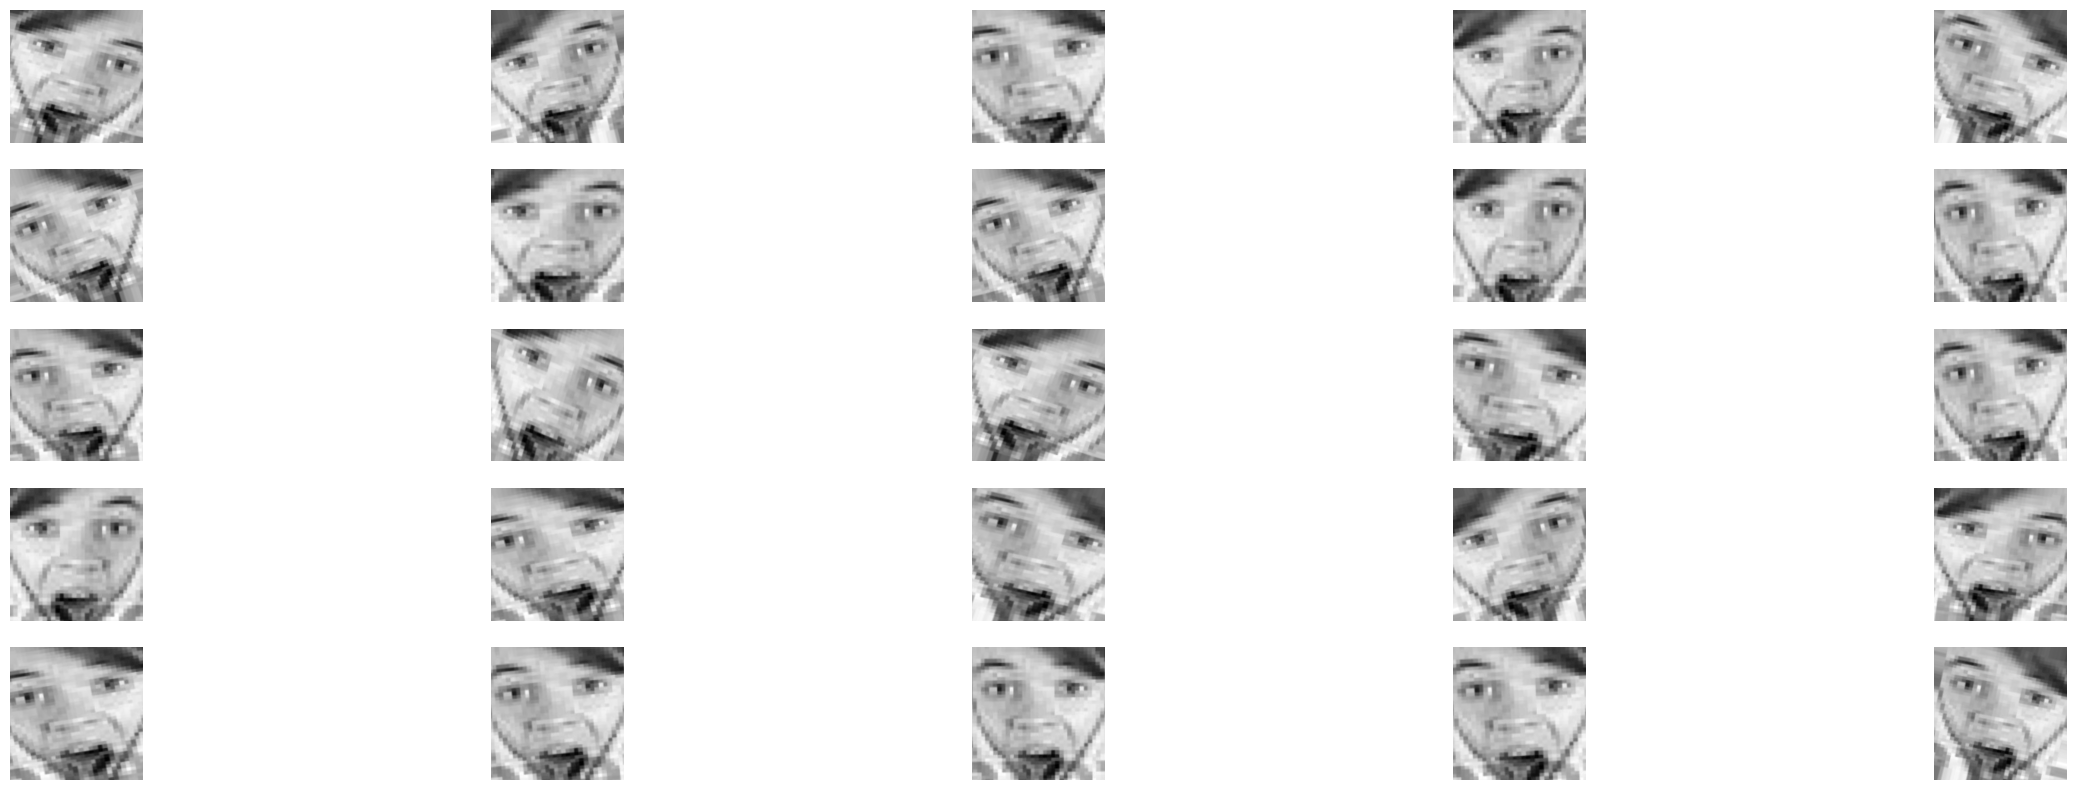

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
# MODEL
INPUT_SHAPE = image.shape
#print('INPUT SHAPE: ',  INPUT_SHAPE)
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

# base_model.add(tf.keras.layers.Rescaling(1./255))

base_model.add(layers.Conv2D(filters=30, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV01'))
base_model.add(layers.BatchNormalization(name='BNOR01'))
base_model.add(layers.Activation('relu', name='RELU01'))
base_model.add(layers.Dropout(0.2, name='DROP01'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0102'))

base_model.add(layers.Conv2D(filters=60, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV02'))
base_model.add(layers.BatchNormalization(name='BNOR02'))
base_model.add(layers.Activation('relu', name='RELU02'))
base_model.add(layers.Dropout(0.2, name='DROP02'))

base_model.add(layers.MaxPool2D(pool_size=(2,2), name='MP0203'))

base_model.add(layers.Conv2D(filters=120, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV03'))
base_model.add(layers.BatchNormalization(name='BNOR03'))
base_model.add(layers.Activation('relu', name='RELU03'))
base_model.add(layers.Dropout(0.2, name='DROP03'))

base_model.add(layers.GlobalAveragePooling2D(name='MXAV01'))

base_model.add(layers.Flatten(name='FLAT01'))

base_model.add(layers.Dense(32, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='DENS01'))
base_model.add(layers.BatchNormalization(name='BNOR04'))
base_model.add(layers.Activation('relu', name='RELU04'))
base_model.add(layers.Dropout(0.2, name='DROP04'))

base_model.add(layers.Dense(8, kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),  name='DENS02'))
base_model.add(layers.Activation('softmax', name='SOFT01'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV01 (Conv2D)             (None, 224, 224, 30)      300       
                                                                 
 BNOR01 (BatchNormalization)  (None, 224, 224, 30)     120       
                                                                 
 RELU01 (Activation)         (None, 224, 224, 30)      0         
                                                                 
 DROP01 (Dropout)            (None, 224, 224, 30)      0         
                                                                 
 MP0102 (MaxPooling2D)       (None, 112, 112, 30)      0         
                                                                 
 CONV02 (Conv2D)             (None, 112, 112, 60)      16260     
                                                                 
 BNOR02 (BatchNormalization)  (None, 112, 112, 60)    

In [10]:
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
outputs = base_model(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 86584     
                                                                 
Total params: 86,584
Trainable params: 86,100
Non-trainable params: 484
_________________________________________________________________


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-11-16 09:02:29.241844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-11-16 09:02:29.865746: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(8, 8)


In [13]:
print('CNN output format')
print(' '.join('{:^12s}'.format(el) for el in class_names))
for row in feature_batch.numpy():
   print(' '.join('{:^12.2f}'.format(el) for el in row))

CNN output format
   anger       contempt     disgust        fear      happiness    neutrality    sadness      surprise  
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    
    0.00         0.00         0.00         0.00         0.00         0.00         0.00         1.00    


In [14]:
print('Dataset label format')
label_batch.numpy()

Dataset label format


array([0, 2, 3, 6, 4, 6, 6, 6], dtype=int32)

In [15]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [16]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [17]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

277/277 [==============================] - 8s 28ms/step - loss: 15.6104 - accuracy: 0.1295
initial loss: 15.61
initial accuracy: 0.13


In [18]:
initial_epochs = 75
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/75
1108/1108 [==============================] - 142s 126ms/step - loss: 2.1740 - accuracy: 0.1583 - val_loss: 2.1528 - val_accuracy: 0.1828
Epoch 2/75
1108/1108 [==============================] - 137s 124ms/step - loss: 2.0590 - accuracy: 0.1987 - val_loss: 2.0301 - val_accuracy: 0.2107
Epoch 3/75
1108/1108 [==============================] - 144s 130ms/step - loss: 2.0261 - accuracy: 0.2137 - val_loss: 2.2410 - val_accuracy: 0.2098
Epoch 4/75
1108/1108 [==============================] - 148s 134ms/step - loss: 1.9998 - accuracy: 0.2227 - val_loss: 2.0321 - val_accuracy: 0.2608
Epoch 5/75
1108/1108 [==============================] - 143s 129ms/step - loss: 1.9956 - accuracy: 0.2332 - val_loss: 2.1331 - val_accuracy: 0.2162
Epoch 6/75
1108/1108 [==============================] - 139s 126ms/step - loss: 1.9762 - accuracy: 0.2356 - val_loss: 2.7479 - val_accuracy: 0.1467
Epoch 7/75
1108/1108 [==============================] - 137s 124ms/step - loss: 1.9517 - accuracy: 0.2471 - val_

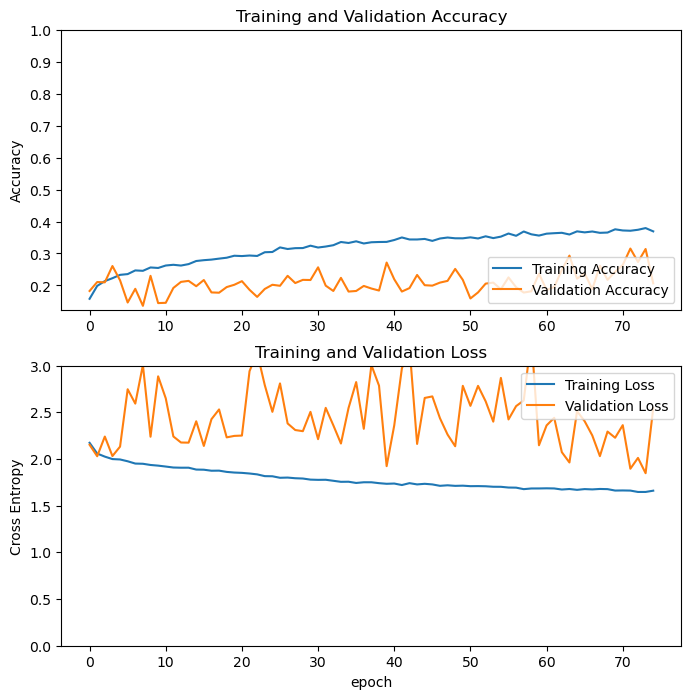

In [19]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
Labels = []
Predss = []
count = 0
for batch, labels in validation_dataset:
    logits = model.predict_on_batch(batch)
    preds  = np.argmax(logits, axis=1) 
    Predss += preds.tolist()
    Labels += labels.numpy().tolist()
    count  += 1

In [21]:
print('Confusion matrix')
confusion = confusion_matrix(Labels, Predss)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in confusion:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

Confusion matrix
anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
10           0            0            0            64           75           114          0           
2            0            0            0            60           185          39           0           
2            0            0            0            59           137          86           0           
6            0            0            0            121          82           67           5           
15           0            0            0            123          24           96           0           
0            0            0            0            24           189          78           0           
2            0            0            0            39           108          117          0           
1            0            0            0            120          72           75           19          
===
Precision per class
anger        contempt  

/tmp/ipykernel_16115/2616201212.py:11: RuntimeWarning: invalid value encountered in divide
  print(' '.join('{:<12.2f}'.format(el) for el in num/den))
/tmp/ipykernel_16115/2616201212.py:13: RuntimeWarning: invalid value encountered in divide
  print('mean precision: {:<12.2f}'.format(np.mean(num/den)))


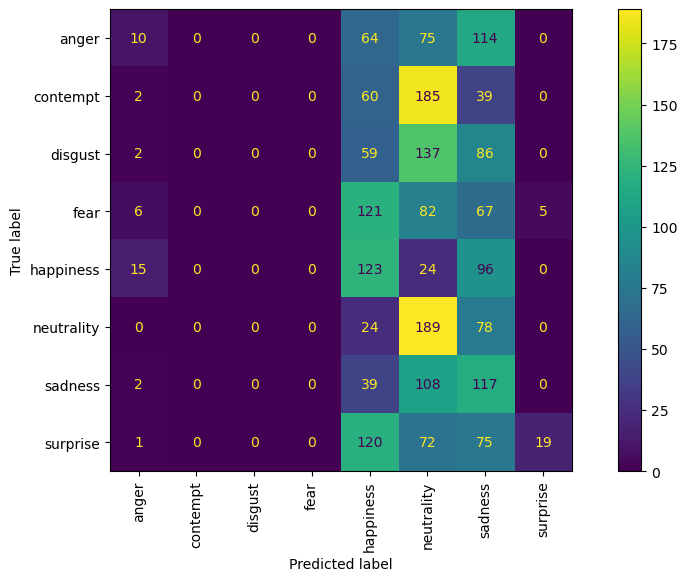

In [22]:
fig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay.from_predictions(Labels, Predss, normalize=None, display_labels=class_names, xticks_rotation='vertical', values_format='d', ax=ax)

55/55 [==============================] - 2s 27ms/step - loss: 2.4272 - accuracy: 0.2432
Test accuracy : 0.24318182468414307
pred [[0.1181167  0.00937828 0.10233085 0.01334375 0.21790466 0.21098149
  0.3038053  0.02413898]
 [0.25050682 0.00664871 0.12942947 0.01006425 0.34157822 0.07451059
  0.16970307 0.01755889]
 [0.05981934 0.00261158 0.02292754 0.00652455 0.08538178 0.5246797
  0.289131   0.00892458]
 [0.15361732 0.00381287 0.06383999 0.00370125 0.1481953  0.23277679
  0.38926    0.00479649]
 [0.06898685 0.00089733 0.01893387 0.00215638 0.34151322 0.31150812
  0.24559201 0.01041221]
 [0.06305218 0.0089732  0.06763069 0.0042556  0.20254986 0.41328704
  0.23342818 0.00682317]
 [0.10353544 0.0155198  0.0324886  0.01758132 0.48395953 0.16074973
  0.16344191 0.02272364]
 [0.03956771 0.01690275 0.01733642 0.00141393 0.50880855 0.2515957
  0.16354498 0.00082988]]
Predictions:
 [6 4 5 6 4 5 4 4]
Labels:
 [5 4 5 6 4 6 0 1]
Classes:
 ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neut

IndexError: index 8 is out of bounds for axis 0 with size 8

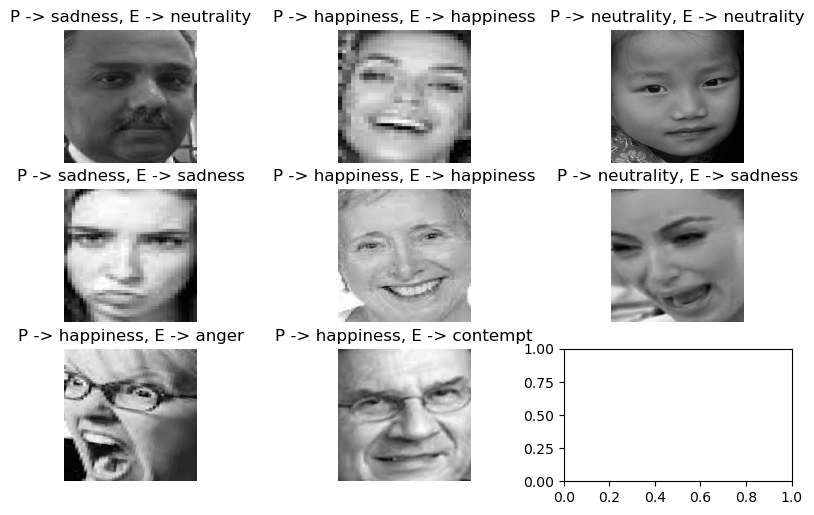

In [23]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")